In [1]:
# important library
import psycopg2
import psycopg2.extras
import sys
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
from PIL import Image
import PIL.Image
import collections
import io
from IPython.display import Image
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd

In [2]:
# connect to database. Postgres must be opened!
conn_string = "host='localhost' dbname='WTP_NUS_library'"
print ("Connecting to database\n	->%s" % (conn_string))
conn = psycopg2.connect(conn_string)
print ("Connected!\n")

Connecting to database
	->host='localhost' dbname='WTP_NUS_library'
Connected!



In [3]:
# all users
db_users = pd.read_sql_query ("SELECT * FROM \"user\"", conn)
# number of submission for each users
db_count_submissions = pd.read_sql_query("""SELECT author_id,COUNT(scenario.id) as n FROM SCENARIO GROUP BY author_id ORDER BY author_id""",conn)
# latest submission
db_scenarios_late = pd.read_sql_query("SELECT id, author_id, last_update, description, image, encode(geometry,'escape') as geo FROM scenario as a WHERE id = (SELECT max(b.id) FROM scenario as b where a.author_id = b.author_id) ORDER BY author_id", conn)

In [4]:
# all user actions
db_user_scenario_load =pd.read_sql_query( "SELECT * FROM user_scenario_load",conn)
db_user_scenario_update =pd.read_sql_query( "SELECT * FROM user_scenario_update",conn)
db_user_scenario_action =pd.read_sql_query( "SELECT * FROM user_scenario_action",conn)

In [5]:
# all cross feedback
db_criterion = pd.read_sql_query( "SELECT * FROM criterion",conn)
db_vote = pd.read_sql_query( "SELECT * FROM vote",conn)
db_peer_review = pd.read_sql_query( "SELECT * FROM review",conn)
db_expert_review = pd.read_sql_query("SELECT * FROM  expert_review",conn)
db_voter_score = pd.read_sql_query("SELECT * FROM vote_rating", conn)
db_voter_scenario = pd.read_sql_query("SELECT * FROM scenario", conn)

In [6]:
# final grade and ratings
db_grade = pd.read_sql_query("SELECT * FROM current_scenario", conn)

In [7]:
#Short cuts for important tables
ld = db_user_scenario_load
ud = db_user_scenario_update
ac = db_user_scenario_action
lt = db_scenarios_late

In [9]:
lt

,id,author_id,last_update,description,image,geo
0,12,3,2018-01-21 09:23:24.601339+00:00,,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1b"",""lon"":103.830289094693,""..."
1,1,11,2018-01-20 08:48:59.247419+00:00,,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1a"",""lon"":103.84056835,""lat""..."
2,2,12,2018-01-20 08:57:10.925012+00:00,Evertafkdkj sdfsf hello!,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1a"",""lon"":103.84056835,""lat""..."
3,3,15,2018-01-21 06:58:45.763373+00:00,jhkjhjlk,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1b"",""lon"":103.830289094693,""..."
4,4,16,2018-01-21 06:59:28.594111+00:00,,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1a"",""lon"":103.84056835,""lat""..."
5,5,17,2018-01-21 07:00:16.297330+00:00,,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""properties"":{},""geometry"":{""type"":""FeatureCo..."
6,7,18,2018-01-21 07:26:30.269080+00:00,Test 1,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1a"",""lon"":103.84056835,""lat""..."
7,9,20,2018-01-21 08:34:52.451539+00:00,,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1a"",""lon"":103.84056835,""lat""..."
8,10,21,2018-01-21 08:44:27.082751+00:00,this looks great,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1b"",""lon"":103.830289094693,""..."
9,11,25,2018-01-21 09:20:29.692103+00:00,,"[b'\x89', b'P', b'N', b'G', b'\r', b'\n', b'\x...","{""name"":""Exercise_1b"",""lon"":103.830289094693,""..."


# Reading data and data cleansing

In [8]:
## Extract the geojson data from all designs

regex = re.compile(r'\\(?![/u"])')
for i, geo_val in enumerate(db_scenarios_late.geo):
  #Select if Exercise 1a, 1b or 1c should be chosen. It is the 19th letter in each db_scenarios_late.geo file
  if lt.geo[i][19]=='a':
    fixed = regex.sub(r"\\\\", geo_val) #remove the "/" in some fields to for json conversion
    b = json.loads(fixed)
    # this would remove an empty MultiLineString object so that it can be displayed in the current qua-viewer. However the shape is still distorted because of the limitation of allowed vertex
    with open("output/geo_a_" + str(db_scenarios_late.loc[i,'author_id']) + ".json","w") as f:
        json.dump(b,f)

In [10]:
len(db_scenarios_late.geo)

72

In [9]:
#Read the original geojson file for the exercise
geo = gpd.read_file('Exercise_1a_reflex_for_upload.geojson')

In [10]:
#Create dictionary with all geojson files for exercise 1a
geo_a={}
for i,j in enumerate(lt['author_id']):
    if lt.geo[i][19]=='a':
        geo_a["geo_author_{0}".format(j)]= gpd.read_file('output/geo_a_'+str(j)+'.json')

In [96]:
# Create list of all authors that worked on Exercise 1a
author_id_a = []
for i,j in enumerate(lt['author_id']):
    if lt.geo[i][19]=='a':
        author_id_a.append(j)
# Delete buggy submissions (manually detected)
y=[16]
author_id_a = sorted(list(set(author_id_a).difference(set(y))))

In [12]:
#Data correction: For 'Chinatown, Central Area', the precinctID is missing in the original data set
for j in list(author_id_a):
    for i in range(0,len(geo_a['geo_author_'+str(j)])):
        if geo_a['geo_author_'+str(j)]['precinctName'][i] == "Chinatown, Central Area":
            geo_a['geo_author_'+str(j)].loc[i,'precinctID'] = 102
        if geo_a['geo_author_'+str(j)]['name'][i] == "greenery small":
            geo_a['geo_author_'+str(j)].loc[i,'precinctID'] = 401
        if geo_a['geo_author_'+str(j)]['name'][i] == "greenery medium":
            geo_a['geo_author_'+str(j)].loc[i,'precinctID'] = 402
        if geo_a['geo_author_'+str(j)]['name'][i] == "greenery large":
            geo_a['geo_author_'+str(j)].loc[i,'precinctID'] = 403
#Overwrite existing .json files with updated precinctID
    with open('output/geo_a_'+str(j)+'.json', 'w') as f:
        f.write(geo_a['geo_author_'+str(j)].to_json())
#Change original geojson file with added precinctID for the greenery
for i in range(1,len(geo)):
    if geo.loc[i,'name'] == 'greenery small':
        geo.loc[i,'precinctID'] = 401
    if geo.loc[i,'name'] == 'greenery medium':
        geo.loc[i,'precinctID'] = 402
    if geo.loc[i,'name'] == 'greenery large':
        geo.loc[i,'precinctID'] = 403
with open('Exercise_1a_reflex_for_upload_updated.json', 'w') as f:
        f.write(geo.to_json())

Calculating the frequency of objects

In [74]:
# Write function for the the number of elements placed

def counter_old(file,obj):
    #Check if file is a string
    if isinstance(file, str) == False:
        print('First variable must be a string variable')
    
    #Extract the integers/numbers out of a string
    import re
    author_id = re.findall(r'\d+', file)

    import geopandas as gpd
    file = gpd.read_file('output/'+file+'.json')
    #Here it is important to take the updated version of the original source file as 'greenery' needs values for 'precinctID'.
    geo = gpd.read_file('Exercise_1a_reflex_for_upload_updated.json')
    
    
    if obj == 'ALL':
        #choose all buildings typologies, incl. greenery
        colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303,401,402,403]
    if obj == 'buildings':
        #choose all building typologies
        colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]
    if obj == 'low-rise':
        #choose all low-rise
        colnames_num = [101,102]
    if obj == 'mid-rise':
        #choose all mid-rise
        colnames_num = [201,202,301]
    if obj == 'high-rise':
        #choose all high-rise
        colnames_num = [203,204,205,206,207,302,303]
    if obj == 'HDB':
        #choose all HDB
        colnames_num = [201,202,203,204,205,206,207]
    if obj == 'Condo':
        #choose all Condo
        colnames_num = [301,302,303]
    if obj == 'mixed-use':
        #choose all building typologies that have a mixed-use
        colnames_num = [102,202,203,204]
    if obj == 'green_elements':
        #choose all building typologies that have a green elements
        colnames_num = [401,402,403]
    if obj in [101,102,201,202,203,204,205,206,207,301,302,303,401,402,403]:
        #choose the specific typology
        colnames_num = [obj]
        
    #Create colnames for dataframe
    colnames=[]
    for i in colnames_num:
        colnames.append('count_'+str(i))
    
    import pandas as pd
    freq = pd.DataFrame(columns=colnames)  # dataframe
    
    import collections
    for k in colnames_num:
        freq.loc[0,'count_'+str(k)] = collections.Counter(file.precinctID)[k]-collections.Counter(geo.precinctID)[k]

    #Adjustment of the frequencies
    
    # Adjusting count by number of group elements for each precinct typology

    if 'count_101' in freq.columns:
        freq['count_101']= freq['count_101']/2
    if 'count_102' in freq.columns:
        freq['count_102'] = freq['count_102']/3
    if 'count_201' in freq.columns:
        freq['count_201'] = freq['count_201']/2
    if 'count_202' in freq.columns:
        freq['count_202'] = freq['count_202']/3
    if 'count_203' in freq.columns:
        freq['count_203'] = freq['count_203']/4
    if 'count_204' in freq.columns:
        freq['count_204'] = freq['count_204']/3
    if 'count_205' in freq.columns:
        freq['count_205'] = freq['count_205']/3
    if 'count_206' in freq.columns:
        freq['count_206'] = freq['count_206']/2
    if 'count_207' in freq.columns:
        freq['count_207'] = freq['count_207']/3
    if 'count_301' in freq.columns:
        freq['count_301'] = freq['count_301']/2
    if 'count_302' in freq.columns:
        freq['count_302'] = freq['count_302']/3
    if 'count_303' in freq.columns:
        freq['count_303'] = freq['count_303']/2
        
    freq.insert(len(colnames),'total', freq.values.sum())
    
    freq = freq.astype(int)
    #Add author_id to the dataframe as first (0th) row
    freq.insert(0, 'author_id', author_id, allow_duplicates=False)
    return freq

Calculating averages for specific objects and object groups

In [101]:
#Calculating the average for specific types, here just one example

# Defining which authors contributed useful submissions
# Delete non-useful submissions (manually decided, quite strict), author_id 16 was already deleted before
x = [11,12,18,20,26,27,28,50,53,55,94,106,108,109,116,117,122,120,135,137]
author_id_a = sorted(list(set(author_id_a).difference(set(x))))
#author_id_a = pd.DataFrame(author_id_a, columns = ['author_id_a'])

In [272]:
def counter_old_mean(authors,obj):
   
    #Input for authors: list of author_id
    s = pd.DataFrame()
    for i in authors:
        s = s.append(counter_old('geo_a_'+str(i),obj))
    #s = float(s / len(authors))
    col = list(s.columns.values)

    t = s[col[1:len(col)]].mean(axis=0)
    t = list(t)
    return col[1:len(col)], t

In [371]:
col = counter_old_mean(author_id_a,'ALL')[0]

colnames = []

for k in col:
    colnames.append(dic[k])

In [399]:
# Define function for plotting barchar from the average number of objects

def counter_old_bar(authors, obj= 'ALL',total = False):
    
    pf = pd.read_csv('Precincts_final.csv')

    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303,401,402,403]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.name[k]
    dic['total']='total'

    col, mean_count = counter_old_mean(authors,obj)
    
    if total == False:
        col.remove('total')
        del mean_count[-1]
    
    colnames = []
    for k in col:
        colnames.append(dic[k])
    
    plt.bar(np.arange(len(mean_count)),mean_count,align='center', color=['#7A9E7E'])
    plt.xticks(np.arange(len(mean_count)),colnames,rotation='vertical')
    plt.title("Average number of objects")
    #plt.savefig('figures/fig_bar_'+str(i)+'.png')
    plt.show()

Calculating 'Number Of Units'

In [519]:
def units_old(file):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col = counter_old(file,'buildings')
    col = col.drop('total',axis=1)
    col = col.drop('author_id',axis=1)
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.numberOfUnits[k]
    
    s = 0
    for i in range(0,len(col.columns)):
        s += dic[col.columns.values[i]] * col[col.columns.values[i]][0]
    s = int(s)   
    return s

In [512]:
def units_old_mean(authors):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col, val = counter_old_mean(authors,'buildings')
    del col[-1]
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.numberOfUnits[k]
    
    s = 0
    for i in range(0,len(col)):
        s += (dic[col[i]] * val[i])
        
    return s

Calculating the total tile area, total plot area and GPR

In [564]:
def tile_area_old(file):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col = counter_old(file,'buildings')
    col = col.drop('total',axis=1)
    col = col.drop('author_id',axis=1)
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.tileArea[k]
    
    a = 0
    for i in range(0,len(col.columns)):
        a += dic[col.columns.values[i]] * col[col.columns.values[i]][0]  
        
    part = round((a / 1.7) * 100,2)
    
    return a, part

In [565]:
def tile_area_old_mean(authors):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col, val = counter_old_mean(authors,'buildings')
    del col[-1]
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.tileArea[k]
    
    a = 0
    for i in range(0,len(col)):
        a += (dic[col[i]] * val[i])
        
    part = round((a / 1.7) * 100,2)
    
    return a, part

In [566]:
def plot_area_old(file):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col = counter_old(file,'buildings')
    col = col.drop('total',axis=1)
    col = col.drop('author_id',axis=1)
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.plotArea[k]
    
    a = 0
    for i in range(0,len(col.columns)):
        a += dic[col.columns.values[i]] * col[col.columns.values[i]][0]  
        
    part = round((a / 1.7) * 100,2)
    
    return a, part

In [567]:
def plot_area_old_mean(authors):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col, val = counter_old_mean(authors,'buildings')
    del col[-1]
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.plotArea[k]
    
    a = 0
    for i in range(0,len(col)):
        a += (dic[col[i]] * val[i])
        
    part = round((a / 1.7) * 100,2)
    
    return a, part

In [574]:
def gpr_old(file):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col = counter_old(file,'buildings')
    col = col.drop('total',axis=1)
    col = col.drop('author_id',axis=1)
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.floorArea[k]
    
    a = 0
    for i in range(0,len(col.columns)):
        a += dic[col.columns.values[i]] * col[col.columns.values[i]][0]  
        
    gpr = round(a / 1.7,2)
    
    return gpr, a

In [572]:
def gpr_old_mean(authors):
    
    pf = pd.read_csv('Precincts_final.csv')
    
    col, val = counter_old_mean(authors,'buildings')
    del col[-1]
    
    colnames_num = [101,102,201,202,203,204,205,206,207,301,302,303]

    dic = {}
    for k,l in enumerate(colnames_num):
        dic['count_'+str(l)]=pf.floorArea[k]
    
    a = 0
    for i in range(0,len(col)):
        a += (dic[col[i]] * val[i])
        
    gpr = round(a / 1.7,2)
    
    return gpr, a

In [590]:
tile_area_old

[29, 59, 61, 68, 79, 83, 87, 89, 90, 92, 93, 105, 107, 110, 111, 112, 123, 130]

In [625]:
x = []
y = []
for i in author_id_a:
    x.append(units_old('geo_a_'+str(i)))
    y.append(tile_area_old('geo_a_'+str(i))[0])


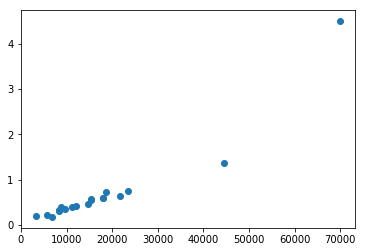

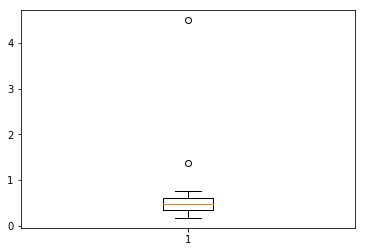

In [626]:
#x.append(70000)
#y.append(4.5)
#If 70000 units should be built on this ground (4.5 as far as I know), 26444 must be in average built on that site (size: 1.7).
plt.scatter(x,y)
plt.show()
plt.boxplot(y)
plt.show()

In [ ]:
# Calculating Gross Flot Ratio:
# https://en.wikipedia.org/wiki/Floor_area_(building)#In_Singapore
# The NUS campus and ONLINE study worked with two different study areas:
# Study area NUS Campus [in square kilometer]
area_total = 1.7
#Study areas for online study
area_1 = 0.546715
area_2 = 0.322409
#Please note that some participants just built on area_1 (where the spawn point of objects was)
# The areas for each object can be found in prec_desc
# Explanation: plotArea: area of the building plot (without the surrounding green), floorArea: levels*plotArea, 
# tileArea: area of the platform (greenery around building + plotArea), floorAreaRatio: floorArea/tileArea
# Greeneries do not need to be considered as they do not count for the GFA
